In [1]:
# (1)  #Import libraries;

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, Adam

In [2]:
# (2) Loading MNIST Dataset;

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# (3) Scale the inputs in range of (-1, +1) for better training;

x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

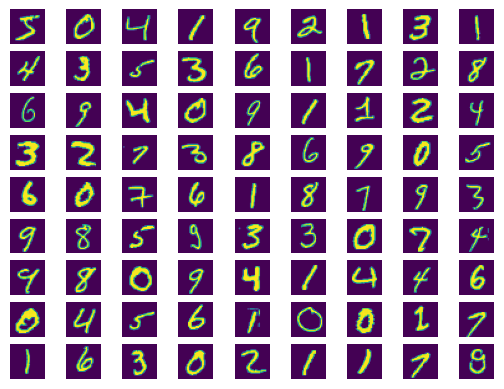

In [4]:
# (4) Plot some example images from the training datasets;

for i in range(81):
  plt.subplot(9, 9, i+1)
  plt.axis("off")
  #plot raw pixel data
  plt.imshow(x_train[i])
plt.show()

In [5]:
# (5) Flattening 3D datasets to 2D datasets and converting the image size from 28*28 
#     to 684

N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [6]:
# (6) Define the Generator Model;

latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i, x)
  return model

In [7]:
# (7) Define the Discriminator Model;

def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [8]:
# (8) Build and compile the discriminator;

discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

C:\Users\HP\anaconda3\envs\abhijitg_env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
# (9) Build the Generator;

generator = build_generator(latent_dim)

In [10]:
# (10) Create Noise Sample;

z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

In [11]:
#(11) Create generator model;

combined_model_gen = Model(z, fake_pred)

In [12]:
# (12) Compile the combined model;

combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [13]:
# (13) Define the parameters for training GANs;

batch_size = 32
epochs = 12000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# (a) Store generator and discriminator loss in each epoch;

g_losses = []
d_losses = []

# (b) Create a file for generator to create and save images;

if not os.path.exists('GAN_Images'):
  os.makedirs('GAN_Images')

In [14]:
# (14) Create sample images;

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # (a) Rescale images 0 - 1;
    
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):  #5*5 loop implies there will be 49 images on page
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("GAN_Images/%d.png" % epoch)
  plt.close()

In [22]:
# (15) Train the discriminator followed by the generator to generate the images;

for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size) #Select a random batch of images
  real_imgs = x_train[idx]  #Train the discriminator

  noise = np.random.randn(batch_size, latent_dim)  #Generator for generating fake images
  fake_imgs = generator.predict(noise)
    
  # (a) Train the discriminator;

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #Both loss and accuracy are returned for the real images
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #Both loss and accuracy are returned for the fake images
  d_loss = 0.5 * (d_loss_real + d_loss_fake) #Average loss
  d_acc  = 0.5 * (d_acc_real + d_acc_fake) #Average accuracy

  # (b) Train the generator;
    
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
    
  # (c) Here we are attempting to fool the discriminator that generate images are real. 
#       Due to this reason, we are labeling it as 1.

#       Repeat the step!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  d_losses.append(d_loss)  #Save the loss at each epoch
  g_losses.append(g_loss)
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

1/1 [==============================] - 0s 32ms/step
epoch: 4801/12000, d_loss: 0.71, d_acc: 0.48, g_loss: 0.81
1/1 [==============================] - 0s 31ms/step
epoch: 4901/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 31ms/step
epoch: 5001/12000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 31ms/step
epoch: 5101/12000, d_loss: 0.62, d_acc: 0.77, g_loss: 0.86
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step
epoch: 5201/12000, d_loss: 0.74, d_acc: 0.45, g_loss: 0.76
1/1 [==============================] - 0s 31ms/step
epoch: 5301/12000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.75
1/1 [==============================] - 0s 31ms/step
epoch: 5401/12000, d_loss: 0.66, d_acc: 0.56, g_loss: 0.83
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step
epoch: 5501/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 0.79
1/1 [==============================] - 0s 31ms/step
epoch: 5601/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.85
1/1 [==============================] - 0s 47ms/step
epoch: 5701/12000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
epoch: 5801/12000, d_loss: 0.71, d_acc: 0.59, g_loss: 0.82
1/1 [==============================] - 0s 31ms/step
epoch: 5901/12000, d_loss: 0.68, d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 31ms/step
epoch: 6001/12000, d_loss: 0.65, d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step
epoch: 6101/12000, d_loss: 0.65, d_acc: 0.62, g_loss: 0.79
1/1 [==============================] - 0s 29ms/step
epoch: 6201/12000, d_loss: 0.72, d_acc: 0.44, g_loss: 0.82
1/1 [==============================] - 0s 31ms/step
epoch: 6301/12000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 43ms/step
epoch: 6401/12000, d_loss: 0.68, d_acc: 0.48, g_loss: 0.77
1/1 [==============================] - 0s 31ms/step
epoch: 6501/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.80
1/1 [==============================] - 0s 47ms/step
epoch: 6601/12000, d_loss: 0.68, d_acc: 0.64, g_loss: 0.82
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step
epoch: 6701/12000, d_loss: 0.67, d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 47ms/step
epoch: 6801/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.84
1/1 [==============================] - 0s 41ms/step
epoch: 6901/12000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.73
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step
epoch: 7001/12000, d_loss: 0.68, d_acc: 0.58, g_loss: 0.82
1/1 [==============================] - 0s 47ms/step
epoch: 7101/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.78
1/1 [==============================] - 0s 47ms/step
epoch: 7201/12000, d_loss: 0.69, d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step
epoch: 7301/12000, d_loss: 0.70, d_acc: 0.47, g_loss: 0.81
1/1 [==============================] - 0s 48ms/step
epoch: 7401/12000, d_loss: 0.66, d_acc: 0.59, g_loss: 0.80
1/1 [==============================] - 0s 40ms/step
epoch: 7501/12000, d_loss: 0.67, d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 39ms/step
epoch: 7601/12000, d_loss: 0.71, d_acc: 0.50, g_loss: 0.81
1/1 [==============================] - 0s 59ms/step
epoch: 7701/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.81
1/1 [==============================] - 0s 48ms/step
epoch: 7801/12000, d_loss: 0.72, d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 40ms/step
epoch: 7901/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 54ms/step
epoch: 8001/12000, d_loss: 0.70, d_acc: 0.50, g_loss: 0.78
1/1 [==============================] - 0s 47ms/step
epoch: 8101/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.82
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
epoch: 8201/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 47ms/step
epoch: 8301/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.77
1/1 [==============================] - 0s 40ms/step
epoch: 8401/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.79
1/1 [==============================] - 0s 47ms/step
epoch: 8501/12000, d_loss: 0.65, d_acc: 0.70, g_loss: 0.81
1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 47ms/step
epoch: 8601/12000, d_loss: 0.68, d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 62ms/step
epoch: 8701/12000, d_loss: 0.69, d_acc: 0.48, g_loss: 0.85
1/1 [==============================] - 0s 47ms/step
epoch: 8801/12000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 32ms/step
epoch: 8901/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 63ms/step
epoch: 9001/12000, d_loss: 0.73, d_acc: 0.47, g_loss: 0.78
1/1 [==============================] - 0s 47ms/step
epoch: 9101/12000, d_loss: 0.68, d_acc: 0.64, g_loss: 0.88
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 74ms/step
epoch: 9201/12000, d_loss: 0.70, d_acc: 0.47, g_loss: 0.86
1/1 [==============================] - 0s 47ms/step
epoch: 9301/12000, d_loss: 0.68, d_acc: 0.53, g_loss: 0.82
1/1 [==============================] - 0s 47ms/step
epoch: 9401/12000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.79
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 61ms/step
epoch: 9501/12000, d_loss: 0.69, d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 47ms/step
epoch: 9601/12000, d_loss: 0.72, d_acc: 0.52, g_loss: 0.73
1/1 [==============================] - 0s 48ms/step
epoch: 9701/12000, d_loss: 0.66, d_acc: 0.56, g_loss: 0.83
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
epoch: 9801/12000, d_loss: 0.66, d_acc: 0.59, g_loss: 0.85
1/1 [==============================] - 0s 48ms/step
epoch: 9901/12000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.82
1/1 [==============================] - 0s 55ms/step
epoch: 10001/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.89
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 47ms/step
epoch: 10101/12000, d_loss: 0.69, d_acc: 0.59, g_loss: 0.82
1/1 [==============================] - 0s 73ms/step
epoch: 10201/12000, d_loss: 0.67, d_acc: 0.50, g_loss: 0.87
1/1 [==============================] - 0s 47ms/step
epoch: 10301/12000, d_loss: 0.65, d_acc: 0.59, g_loss: 0.89
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step
epoch: 10401/12000, d_loss: 0.67, d_acc: 0.64, g_loss: 0.79
1/1 [==============================] - 0s 63ms/step
epoch: 10501/12000, d_loss: 0.66, d_acc: 0.58, g_loss: 0.83
1/1 [==============================] - 0s 32ms/step
epoch: 10601/12000, d_loss: 0.67, d_acc: 0.67, g_loss: 0.82
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 48ms/step
epoch: 10701/12000, d_loss: 0.71, d_acc: 0.56, g_loss: 0.84
1/1 [==============================] - 0s 31ms/step
epoch: 10801/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.87
1/1 [==============================] - 0s 63ms/step
epoch: 10901/12000, d_loss: 0.70, d_acc: 0.56, g_loss: 0.83
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 58ms/step
epoch: 11001/12000, d_loss: 0.73, d_acc: 0.48, g_loss: 0.75
1/1 [==============================] - 0s 62ms/step
epoch: 11101/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 48ms/step
epoch: 11201/12000, d_loss: 0.64, d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 62ms/step
epoch: 11301/12000, d_loss: 0.71, d_acc: 0.52, g_loss: 0.86
1/1 [==============================] - 0s 64ms/step
epoch: 11401/12000, d_loss: 0.67, d_acc: 0.62, g_loss: 0.82
1/1 [==============================] - 0s 59ms/step
epoch: 11501/12000, d_loss: 0.63, d_acc: 0.64, g_loss: 0.86
1/1 [==============================] - 0s 47ms/step
epoch: 11601/12000, d_loss: 0.65, d_acc: 0.59, g_loss: 0.82


1/1 [==============================] - 0s 63ms/step
epoch: 11701/12000, d_loss: 0.73, d_acc: 0.44, g_loss: 0.77
1/1 [==============================] - 0s 62ms/step
epoch: 11801/12000, d_loss: 0.66, d_acc: 0.61, g_loss: 0.82
1/1 [==============================] - 0s 57ms/step
epoch: 11901/12000, d_loss: 0.67, d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 59ms/step


In [ ]:
 #if epoch % 100 == 0:
   # print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}.format()")
  #if epoch % sample_period == 0:
    # sample_images(epoch)

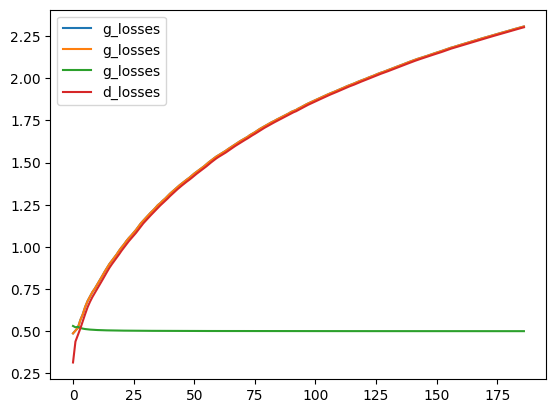

In [23]:
# (16) Plot the loss function;

plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

#                    Observe the Result

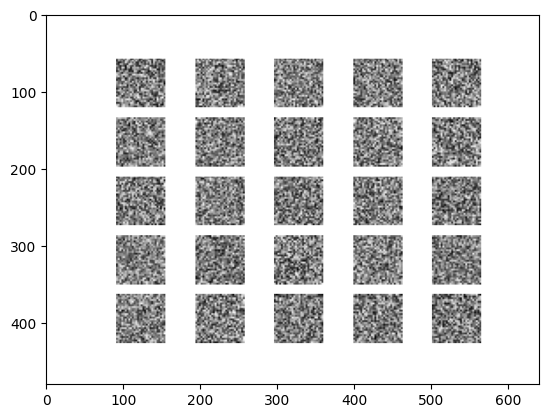

In [25]:
# (17) Plot the generated image at 0 epoch;

from skimage.io import imread
a = imread('GAN_Images/0.png')
plt.imshow(a)

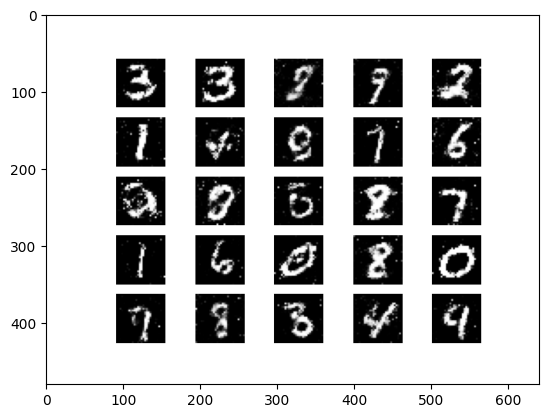

In [26]:
# (18) Plot the generated image at 1000 epoch;

from skimage.io import imread
a = imread('GAN_Images/8800.png')
plt.imshow(a)

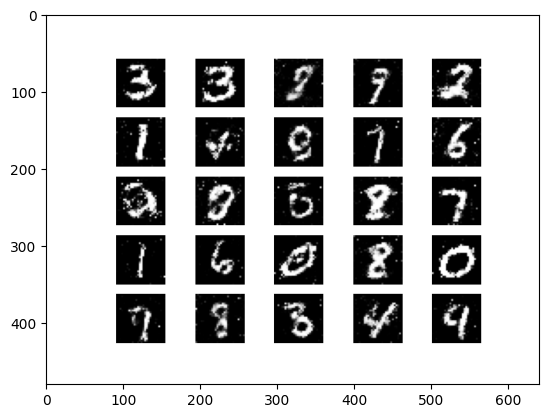

In [27]:
# (19) Plot the generated image at 10000 epoch;

from skimage.io import imread

a = imread('GAN_Images/8800.png')
plt.imshow(a)